In [70]:
%reload_ext autoreload
%autoreload 2

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.040
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


In [10]:
import numpy as np

a = np.load('/home/data/results/expes/encoder/msescores_celebahq_224.npy')

In [11]:
np.mean(a)

0.16516375237703323

In [71]:
from ipyexperiments import IPyExperimentsPytorch

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.025
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


In [72]:
import sys

sys.path.append('/home')
# our models for image to latent learning
# https://github.com/jacobhallberg/pytorch_stylegan_encoder

from asya_utils.model_tools.customdatasets import ImageTestSet
from asya_utils.model_tools.model_loaders import get_stylegan_models, get_encoder
from asya_utils.view_tools import imshow, show_grid
from asya_utils.model_tools.losses import LogCoshLoss
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import cv2
import os
import numpy as np
from glob import glob


from tqdm import tqdm

# for viewing images and testdataset testing
import torch

import torch.nn.functional as F
#from torchvision import utils, transforms, datasets
from torchvision import transforms

import torchvision as tv
import lpips

from fastai.vision.data import imagenet_stats

from Inversion.pytorch_stylegan_encoder.models.image_to_latent import EvalImageLatentDataset

from pathlib import Path
from fastai.vision.all import get_image_files # this is so path will work

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.026
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


In [73]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.024
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


# 1. Data Loading
Let's show the unaligned image and the aligned image side by side 

The images that we will run here are from the **aligned_image_path** which transformed the images in **test_image_path** into good images from the dataset. We assume that the user has run the align_images.py tool to create the aligned images.

In [74]:
def aligned_name(test_name):
    n = os.path.splitext(test_name)
    return n[0] + '_01.png'

def unaligned_name(test_image):
    n = test_image.split('_01')
    return n[0] 

def view_images(test_image_path, aligned_image_path):
    # view information of our test images

    for aligned_image in os.listdir(aligned_image_path):
        if os.path.splitext(aligned_image)[1].lower() not in ['.jpg', '.png', '.jpeg']:
            continue
        print(aligned_image)
        test_image = unaligned_name(aligned_image)
        print(test_image)
        
        try:
            impath = glob.glob(os.path.join(test_image_path, test_image) + '*')[0]
        except IndexError:
            continue
        im_test = cv2.imread(impath)
        
        if not os.path.exists(os.path.join(aligned_image_path, aligned_image)):
            print("error", os.path.join(aligned_image_path, aligned_image))
            continue

        im_align = cv2.imread(os.path.join(aligned_image_path, aligned_image))

        print('image name: {}'.format(test_image))
        print('test image shape:', im_test.shape)
        print('aligned image shape:', im_align.shape)

        plt.imshow(im_test[:, :, ::-1])
        plt.show()
        plt.imshow(im_align[:, :, ::-1])
        plt.show()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.026
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


In [75]:
parent_directory = '/home/data/images'
test_image_path = os.path.join(parent_directory, 'test_images/')
aligned_image_path = os.path.join(parent_directory, 'aligned_images/')
#view_images(test_image_path, aligned_image_path)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.025
･ CPU:          0          0      4,269 MB |
･ GPU:          0          0     21,374 MB |


Get the models necessary (encoder and stylegan generator)

# 2. Get our pre-trained models
Remember that we have 2 encoders, one that gives 18 latent directly and one that gives 1 latent. The model which gives 1 latent is better.

In [76]:
# get our image-to-latent model
#input_size = 224 # normally this is always supposed to be 224 BUT for the 100000_1024_18 it has to be 256 (trained like this)

encoder_checkpoint = 'latent_image_pairs_100000_1024_18.pt'
#encoder_checkpoint = 'latent_image_pairs_500000_1024_1.pt'

if int(encoder_checkpoint.split('_')[-1].split('.')[0]) == 1:
    input_size = 224
else:
    input_size = 256

# this is simply the string with nlatents + input size (used for saving)
config = encoder_checkpoint.split('_')[-1].split('.')[0] + '_' + str(input_size)



# get image_to_latent encoder
image_to_latent = get_encoder(encoder_checkpoint, input_size=input_size)
image_to_latent.eval()

# load trained stylegan generator
# get the stylegan2 pretrained model 
styleganmodel, dis, avglat = get_stylegan_models()
styleganmodel.eval()

input_size: 256


Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:01.462
･ CPU:          1          0      4,273 MB |
･ GPU:         36          2     21,410 MB |


In [80]:
avglat.repeat(18).reshape(18, -1)

tensor([[ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012],
        [ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012],
        [ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012],
        ...,
        [ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012],
        [ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012],
        [ 0.0929,  0.0445,  0.1758,  ..., -0.0597, -0.0414,  0.2012]])

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.028
･ CPU:          0          0      4,275 MB |
･ GPU:          0          0     21,410 MB |


In [62]:
# gpu_experiment = IPyExperimentsPytorch()

# this is the arguments to display the input image (simply to be able to view it again side-by-side with output)
augments1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[.5, .5, .5])
])

# this is for the input into the resnet model
augments2 = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_stats[0],
                         std=imagenet_stats[1])
])

test_filenames = sorted(glob(aligned_image_path + "/*.png"))
test_dataset = ImageTestSet(test_filenames, transforms1=augments1, transforms2=augments2)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=6)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      4,184 MB |
･ GPU:          0          0     15,078 MB |


In [63]:
#####################
### data loading: ###
#####################

parent = '/home/datadrive/asya/datasets/StyleGAN2_ffhq_latent_image_pairs'
basename = 'latent_image_pairs_500000_1024_1'

data_dir = Path(parent) / basename
if not os.path.exists(data_dir):
    raise ValueError("Basename directory does not exist. Please verify.")

filenames = sorted(get_image_files(data_dir))
dlatents = np.load(str(data_dir/'w.npy')) # shape: (nb_samples, 512) or (nb_samples, latent_n, 512) if latent_n != 1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:26.047
･ CPU:      1,102          0      5,291 MB |
･ GPU:          0          0     15,078 MB |


In [64]:
#######################################
#### hyperparameters + dataloaders ####
#######################################

val_ratio = 0.1
cutoff = int(len(filenames) * (1 - val_ratio))
batch_size = 16


augments = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_stats[0], std=imagenet_stats[1])
])

augments_origsize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_stats[0], std=imagenet_stats[1])
])  # origsize


#train_filenames = filenames[:cutoff]
val_filenames = filenames[cutoff:]

#train_latents = dlatents[:cutoff]
val_latents = dlatents[cutoff:]

#train_dataset = EvalImageLatentDataset(train_filenames, train_latents, transforms=augments)
val_dataset = EvalImageLatentDataset(val_filenames, val_latents, transforms1=augments, transforms2=augments1)

#train_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.034
･ CPU:          0          0      4,185 MB |
･ GPU:          0          0     15,078 MB |


In [68]:
input_size

256

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      4,185 MB |
･ GPU:          0          0     15,078 MB |


In [65]:
celeba_path = Path('/home/datadrive/asya/datasets/celeba_hq/val/male')
celeba_files = get_image_files(celeba_path)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.011
･ CPU:          0          0      4,185 MB |
･ GPU:          0          0     15,078 MB |


In [66]:
######## real dataset ###########
celeba = ImageTestSet(celeba_files,
                    transforms1=augments1,
                    transforms2=augments2)
celeba_generator = torch.utils.data.DataLoader(celeba, batch_size=16)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      4,185 MB |
･ GPU:          0          0     15,078 MB |


In [67]:
# define criterions
latent_criterion = LogCoshLoss()
lpips_criterion = lpips.LPIPS(net='alex')
mse_criterion = torch.nn.MSELoss()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.835
･ CPU:          0          0      4,185 MB |
･ GPU:          0          0     15,078 MB |


In [21]:
lpips_total = 0
mse_total = 0



i = 0
for data1, data2 in zip(celeba_generator, celeba_generator_resized):
    print(i, '/', len(celeba_generator))
    
    gpu_experiment = IPyExperimentsPytorch()
    
    im_big, _ = data1
    im_small, _ = data2
    pred_latents = image_to_latent(im_small.to('cuda'))
    img_big_pred, _ = styleganmodel([pred_latents], input_is_latent=True)
    img_big_pred = img_big_pred.to('cpu')
    
    lpips_loss = lpips_criterion(img_big_pred, im_big).reshape((-1)).mean()
    mse_loss = mse_criterion(img_big_pred, im_big)
    
    try:
        all_lpips = np.load('/home/data/results/expes/encoder/pipscores.npy')
        all_mse = np.load('/home/data/results/expes/encoder/msescores.npy')
    except Exception:
        all_lpips = np.zeros(len(celeba_generator))
        all_mse = np.zeros(len(celeba_generator))
    
    
    
    all_lpips[i] = (lpips_loss.item())
    all_mse[i] = (mse_loss.item())
    
    np.save('/home/data/results/expes/encoder/pipscores.npy', all_lpips)
    np.save('/home/data/results/expes/encoder/msescores.npy', all_mse)
    
    del img_big_pred
    
    del gpu_experiment
    
    i += 1

print("MSE:", mse_total / i)
print("LPIPS:", lpips_total / i)
    

0 / 1875

*** Experiment started with the Pytorch backend
Device: ID 0, Quadro GV100 (32508 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   4,570  25,289  32,055 MB  14.26% 
GPU:   1,888  30,619  32,508 MB   5.81% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:12.256
･ CPU:          0          0      7,167 MB |
･ GPU:     12,930     10,130     14,818 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:00:13 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: all_lpips, all_mse, im_big, im_small, lpips_loss, mse_loss, pred_latents

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:    2,597    2,583 MB ( 99.45%)
GPU:   12,930   12,910 MB ( 99.85%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   4,584  25,284  32,055 MB  14.30% 
GPU:   1,908  30,599  32,508 MB   5.87% 


1 / 1875

*** Experiment started with the Pytorch backend
Device: ID 0, Quadro GV100 (32508 RAM)


*** Current state:

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 31.75 GiB total capacity; 25.12 GiB already allocated; 1.19 GiB free; 29.39 GiB reserved in total by PyTorch)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.367
･ CPU:          0          0      7,318 MB |
･ GPU:      4,104          2     31,292 MB |


In [14]:
all_lpips = np.load('/home/data/results/expes/encoder/pipscores.npy')

In [57]:
celeba_generator

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      3,977 MB |
･ GPU:          0          0     15,598 MB |


In [69]:
i = 0
for i, (im_big, im_small) in enumerate(celeba_generator):
    
    #gpu_experiment = IPyExperimentsPytorch()
    
    pred_latents = image_to_latent(im_small.to('cuda'))
    img_big_pred, _ = styleganmodel([pred_latents], input_is_latent=True)
    
    tv.utils.save_image(im_big, '/home/data/results/expes/encoder/celeba_real_bis_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)
    tv.utils.save_image(img_big_pred, '/home/data/results/expes/encoder/celeba_enco_bis_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)
    
    break
#     lpips_loss = lpips_criterion(img_big_pred.to('cpu'), im_big).reshape((-1)).mean()
#     mse_loss = mse_criterion(img_big_pred.to('cpu'), im_big)
    
#     try:
#         all_lpips = np.load('/home/data/results/expes/encoder/pipscores.npy')
#         all_mse = np.load('/home/data/results/expes/encoder/msescores.npy')
#     except Exception:
#         all_lpips = np.zeros(len(celeba_generator))
#         all_mse = np.zeros(len(celeba_generator))
    
    
    
#     all_lpips[i] = (lpips_loss.item())
#     all_mse[i] = (mse_loss.item())
    
#     np.save('/home/data/results/expes/encoder/pipscores.npy', all_lpips)
#     np.save('/home/data/results/expes/encoder/msescores.npy', all_mse)
    
#     del gpu_experiment
    
#     i += 1

# print("MSE:", mse_total / i)
# print("LPIPS:", lpips_total / i)

/home/datadrive/asya/datasets/celeba_hq/val/male/177491.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/008582.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/147379.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/161369.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/108120.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/168307.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/128229.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/059164.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/135598.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/047330.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/032924.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/073717.jpg
(1024, 1024, 3)
/home/datadrive/asya/datasets/celeba_hq/val/male/060154.jpg
(1024, 1024, 3)
/home/datadr

In [116]:
# show_grid(utils.make_grid(im_big, nrow=1, normalize= True, range=(-1, 1)))
# utils.save_image(im_big, '/home/data/results/expes/encoder/gt2.png', nrow=1, normalize= True, range=(-1, 1))

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      4,809 MB |
･ GPU:          0          0     27,588 MB |


In [117]:
# show_grid(utils.make_grid(img_big_pred, nrow=1, normalize= True, range=(-1, 1)))
# utils.save_image(img_big_pred, '/home/data/results/expes/encoder/preds2.png', nrow=1, normalize= True, range=(-1, 1))

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      4,809 MB |
･ GPU:          0          0     27,588 MB |


In [82]:
torch.zeros(18, 512).shape

torch.Size([18, 512])

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.026
･ CPU:          0          0      4,275 MB |
･ GPU:          0          0     21,410 MB |


# 3. Evaluation

## 3.1 On Generated Images
Let's first evaluate our encoder on generated images. For this we need to create a test set of images which we have thanks to our latent/image pairs

In [ ]:
validation_loss = 0

lat_loss_tot = 0
lpips_loss_tot = 0

for i, (images_cpu, images_fullsize, latents_cpu) in enumerate(val_gen, 1):
    
    if i % 100 == 0:    
        print(str(i) + ' / ' + str(len(val_gen)))
   
    with torch.no_grad():
        images, latents = images_cpu.cuda(), latents_cpu.cuda()

        pred_latents = image_to_latent(images)
        #print('latents shape:', latents.shape)
        
        #break
        
        
        pred_images, _ = styleganmodel([latents], input_is_latent=True)
        lat_loss =  latent_criterion(pred_latents, latents)
        lpips_loss = lpips_criterion(pred_images.to('cpu'), images_fullsize).reshape((-1)).mean()
        
#         print("lpips:", lpips_loss.reshape((-1)).mean())
        
        lat_loss_tot += lat_loss.item()
        lpips_loss_tot += lpips_loss.item()


    lat_loss_tot /= i
    lpips_loss_tot /= i

100 / 3125
200 / 3125
300 / 3125
400 / 3125


In [20]:
validation_loss = 0

lat_loss_tot = 0
lpips_loss_tot = 0

for i, (images_cpu, images_fullsize, latents_cpu) in enumerate(val_gen, 1):
    
    if i % 100 == 0:    
        print(str(i) + ' / ' + str(len(val_gen)))
   
    with torch.no_grad():
        images, latents = images_cpu.cuda(), latents_cpu.cuda()

        pred_latents = image_to_latent(images)
        #print('latents shape:', latents.shape)
        
        #break
        
        
        pred_images, _ = styleganmodel([latents], input_is_latent=True)
        #lat_loss =  latent_criterion(pred_latents, latents)
        #lpips_loss = lpips_criterion(pred_images.to('cpu'), images_fullsize).reshape((-1)).mean()
        
#         print("lpips:", lpips_loss.reshape((-1)).mean())
        
        #lat_loss_tot += lat_loss.item()
        #lpips_loss_tot += lpips_loss.item()
        
        tv.utils.save_image(images_fullsize, '/home/data/results/expes/encoder/gen_real_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)
        tv.utils.save_image(pred_images, '/home/data/results/expes/encoder/gen_enco_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)
    


    #lat_loss_tot /= i
    #lpips_loss_tot /= i

KeyboardInterrupt: 

In [84]:
# let's view some images

for i, (images_cpu, latents_cpu) in enumerate(val_gen, 1):
    print(latents_cpu.shape)
    break

torch.Size([64, 512])
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:01.177
･ CPU:          0          6      4,145 MB |
･ GPU:          0          0     26,331 MB |


In [30]:
data[1]

tensor([[[[1.1187, 1.1187, 1.1187,  ..., 1.0844, 1.0673, 1.0502],
          [1.1187, 1.1187, 1.1015,  ..., 1.0844, 1.0673, 1.0502],
          [1.1358, 1.1187, 1.1015,  ..., 1.0844, 1.0673, 1.0673],
          ...,
          [0.8618, 0.8618, 0.8104,  ..., 0.8961, 0.8961, 0.8789],
          [0.8447, 0.8447, 0.7933,  ..., 0.8961, 0.8789, 0.8789],
          [0.8276, 0.8276, 0.7933,  ..., 0.8961, 0.8789, 0.8789]],

         [[1.0805, 1.0805, 1.0805,  ..., 1.0455, 1.0280, 1.0105],
          [1.0805, 1.0805, 1.0630,  ..., 1.0455, 1.0280, 1.0105],
          [1.0980, 1.0805, 1.0630,  ..., 1.0455, 1.0280, 1.0280],
          ...,
          [0.7304, 0.7304, 0.6954,  ..., 0.8529, 0.8354, 0.8354],
          [0.7129, 0.7129, 0.6779,  ..., 0.8354, 0.8179, 0.8179],
          [0.6954, 0.6954, 0.6779,  ..., 0.8354, 0.8179, 0.8179]],

         [[0.7402, 0.7402, 0.7402,  ..., 0.8797, 0.8622, 0.8448],
          [0.7402, 0.7402, 0.7228,  ..., 0.8797, 0.8622, 0.8448],
          [0.7576, 0.7402, 0.7228,  ..., 0

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.027
･ CPU:          0          0      5,606 MB |
･ GPU:          0          0     29,504 MB |


/home/data/images/aligned_images/Tof_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/ValentinBinjacar_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/alberto_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/asya_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/asya_1024_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/cristian_01.png
(1024, 1024, 3)
hi


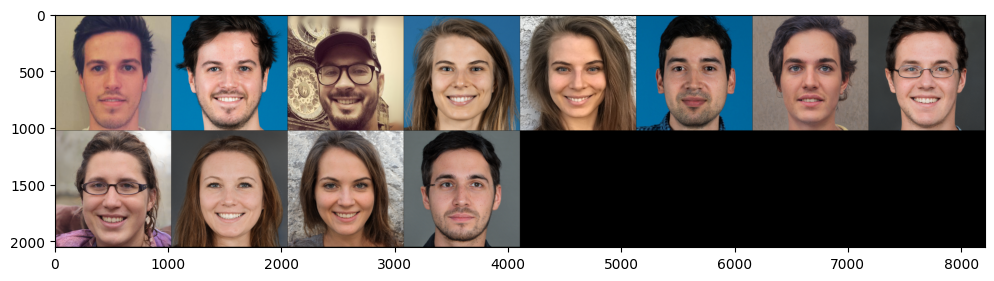

/home/data/images/aligned_images/dmitry_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/gaetan_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/hung_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/indian_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/indman_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/jeff_01.png
(1024, 1024, 3)
hi


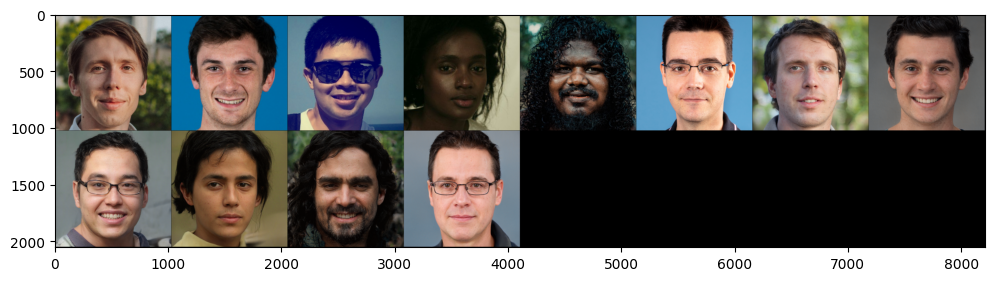

/home/data/images/aligned_images/juliette_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/kobe_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/loicito_01.png
(1024, 1024, 4)
/home/data/images/aligned_images/margo_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/marguerite_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/mcord_01.png
(1024, 1024, 3)
hi


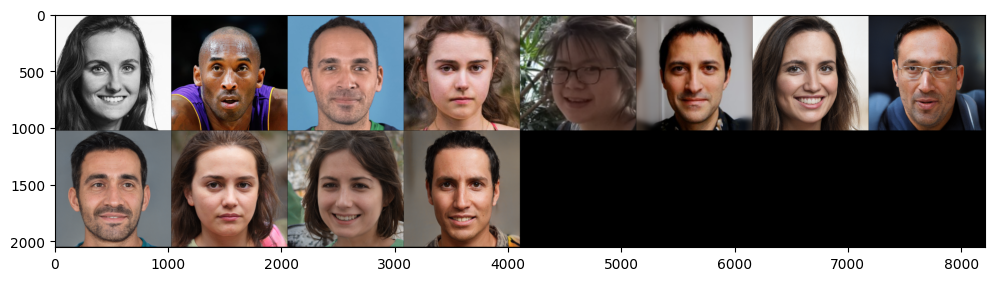

/home/data/images/aligned_images/morgan_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/paola_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/paul_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/rihanna_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/sarah_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/sonia_01.png
(1024, 1024, 3)
hi


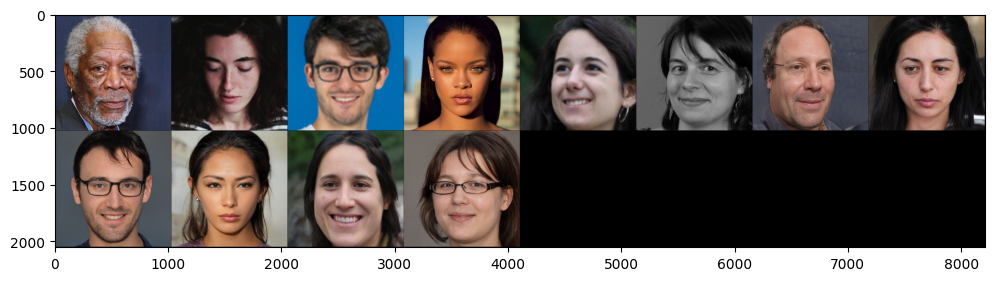

/home/data/images/aligned_images/victor_01.png
(1024, 1024, 3)
/home/data/images/aligned_images/victor_02.png
(1024, 1024, 3)
hi


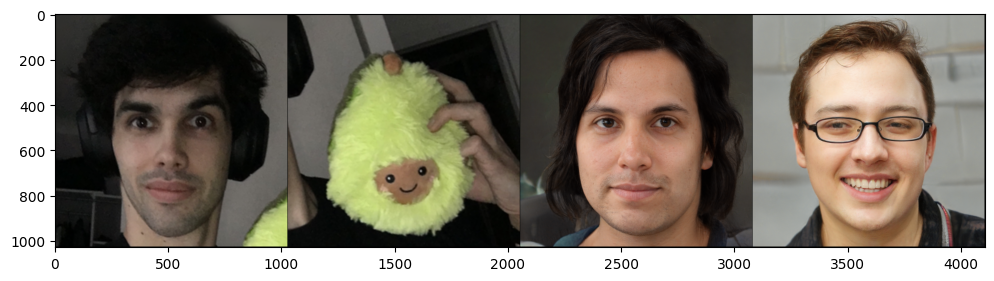

NameError: name 'gpu_experiment' is not defined

In [21]:


savedir = '/home/data/results/expes/encoder'
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
all_outputs = None

# toexit = False

for i, (im_full, images_cpu) in enumerate(test_generator):
        
        
        with torch.no_grad():
            images = images_cpu.cuda() #, latents_cpu.cuda()
            pred_latents = image_to_latent(images)
        
        

        output, _ = styleganmodel([pred_latents], input_is_latent=True)
        
        
        
        # put outputs on cpu
        outputs = torch.cat([im_full, output.cpu()], 0)
        
#         if all_outputs is not None:
#             all_outputs = torch.cat([all_outputs, outputs], 2)
#         else:
#             all_outputs = outputs

        print("hi")
        tv.utils.save_image(output, '/home/data/results/expes/encoder/encoded_bis_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)
        #tv.utils.save_image(im_full, '/home/data/results/expes/encoder/real_{}.png'.format(i), normalize=True, range=(-1, 1), nrow=1)

        
        plot = tv.utils.make_grid(outputs, normalize=True, range=(-1, 1))
        imshow(plot)
        
#         if toexit:
#             break
        
        # remove images and pred_latents to free memory
        #del output
        #del images
        #del pred_latents
        #torch.cuda.empty_cache()
        
        

# plot = tv.utils.make_grid(all_outputs, normalize=True, range=(-1, 1))
# path = os.path.join(savedir, 'all_{}.png'.format(config))
# utils.save_image(all_outputs, path, normalize=True, range=(-1, 1))
# print("saved all images in :" + savedir)

del gpu_experiment

In [ ]:
im_full
plot = utils.make_grid(im_full, normalize=False)
imshow(plot)

In [37]:
for data in test_dataset:
    continue

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.615
･ CPU:          4          7      6,734 MB |
･ GPU:          0          0     29,778 MB |


In [20]:
path = '/home/asya/work_git/recherche/StyleGAN/aligned_images/loicito_01.png'
im = Image.open(path).convert('RGB')

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.041
･ CPU:          0          0      3,020 MB |
･ GPU:          0          0      1,584 MB |


In [21]:
npim = np.asarray(im)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          3          3      3,020 MB |
･ GPU:          0          0      1,584 MB |


In [22]:
npim.shape

(1024, 1024, 3)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      3,020 MB |
･ GPU:          0          0      1,584 MB |


In [37]:
images_cpu

tensor([[[[-2.0152, -2.0152, -2.0152,  ..., -0.9534, -0.9192, -0.9192],
          [-2.0152, -2.0152, -2.0152,  ..., -0.9363, -0.9534, -0.9534],
          [-2.0152, -2.0152, -2.0323,  ..., -0.9363, -0.9363, -0.9363],
          ...,
          [-1.9638, -1.9638, -1.9638,  ..., -1.0562, -1.1932, -1.5014],
          [-1.9638, -1.9638, -1.9638,  ..., -0.6281, -0.4911, -0.6623],
          [-1.9467, -1.9467, -1.9638,  ..., -0.6109, -0.3712, -0.3198]],

         [[-1.8957, -1.8957, -1.8957,  ..., -0.8627, -0.8452, -0.8277],
          [-1.8957, -1.8957, -1.8957,  ..., -0.8452, -0.8627, -0.8452],
          [-1.8957, -1.8957, -1.9132,  ..., -0.8277, -0.8277, -0.8102],
          ...,
          [-1.8431, -1.8431, -1.8431,  ..., -1.0203, -1.1604, -1.4580],
          [-1.8431, -1.8431, -1.8431,  ..., -0.6176, -0.5126, -0.6527],
          [-1.8256, -1.8256, -1.8431,  ..., -0.6001, -0.4076, -0.3375]],

         [[-1.6999, -1.6824, -1.6824,  ..., -0.6890, -0.6541, -0.6367],
          [-1.6824, -1.6824, -

In [38]:
image_to_latent

ImageToLatent(
  (activation): ELU(alpha=1.0)
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [39]:

outputsall = torch.cat([outputs, outputs2], 2)

NameError: name 'outputs2' is not defined

In [ ]:
plot = utils.make_grid(outputsall, normalize=True, range=(-1, 1))
imshow(plot)

In [22]:
# now train a model to optimize w directly from the latent vector !!!

In [13]:
from image_tools import load_images

In [14]:
im = load_images(['/home/asya/work_git/recherche/StyleGAN/aligned_images/juliette_01.png'])

In [15]:
inimage = torch.from_numpy(im).cuda()

In [16]:
inimage.shape

torch.Size([1, 3, 1024, 1024])

In [29]:
class VGGProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.image_size = 256
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1)

    def forward(self, image):
        image = image / torch.tensor(255).float()
        image = F.adaptive_avg_pool2d(image, self.image_size)

        image = (image - self.mean) / self.std

        return image

In [30]:
v = VGGProcessing()

In [33]:
im_n = v(inimage)

In [35]:
im_n.shape

torch.Size([3, 256, 256])

In [36]:
im_n = im_n.unsqueeze(0)

In [37]:
im_n.shape

torch.Size([1, 3, 256, 256])

In [39]:
pred_latent = image_to_latent(im_n)

In [43]:
im, _ = styleganmodel([pred_latent], input_is_latent=True)

In [44]:
plot = utils.make_grid(im, normalize=True, range=(-1, 1))

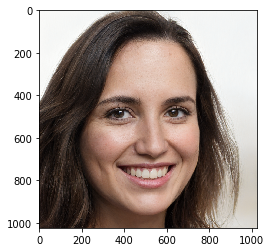

In [45]:
imshow(plot)

In [3]:
from model_tools import get_stylegan_model

In [4]:
stylegan_model = get_stylegan_model()

In [17]:
import sys
path_to_stylegan = '/home/asya/work_git/recherche/StyleGAN/stylegan2-pytorch'
sys.path.insert(0, path_to_stylegan)
from model import Generator

checkpoint = '/home/asya/work_git/recherche/StyleGAN/stylegan2-pytorch/checkpoint/stylegan2-ffhq-config-f.pt'
args_dict = {}
args_dict['device'] = 'cuda'
args_dict['size'] = 1024
args_dict['latent'] = 512
args_dict['n_mlp'] = 8
args_dict['n_latent'] = 18
args_dict['channel_multiplier'] = 2
args_dict['ckpt'] = checkpoint
styleganmodel = Generator(
    args_dict['size'], args_dict['latent'], args_dict['n_mlp'], channel_multiplier=args_dict['channel_multiplier']
).to(args_dict['device'])
checkpoint = torch.load(args_dict['ckpt'])
styleganmodel.load_state_dict(checkpoint['g_ema'])

<All keys matched successfully>

In [20]:
os.listdir('../checkpoint')

['wandb',
 'model_tools.py',
 'jean_01.png',
 'image_to_latent_copy.pt',
 'image_to_latent.pt',
 'stylegan2-ffhq-config-f.pt',
 '.gitignore']

In [7]:
from glob import glob
import os

In [10]:
proj_path = '/home/asya/work_git/recherche/StyleGAN/stylegan2-pytorch/checkpoint/w_projections'

In [20]:
unique_filenames = list(set([os.path.basename(f).split('run')[0][:-1] for f in glob(os.path.join(proj_path, '*'))]))

In [21]:
unique_filenames

['asya_1024_01',
 'victor_02',
 'juliette_01',
 'victor_01',
 'sarah_01',
 'ValentinBinjacar_01',
 'gaetan_01',
 'jean_01',
 'jeff_01',
 'dmitry_01',
 'Tof_01',
 'asya_01',
 'paul_01',
 'valentin_01',
 'sonia_01',
 'cristian_01',
 'marguerite_01',
 'hung_01',
 'alberto_01',
 'paola_01']

In [76]:
# save as numpy arrays of size (18, 512)
for an_f in unique_filenames:
    most_recent_run = sorted(glob(os.path.join(proj_path, an_f + '*[1234567890]')), key=lambda f: int(f.split('_')[-1]))[-1]
    step, w = torch.load(most_recent_run)
    w_numpy = w.cpu().detach().numpy().reshape((-1, 512))
    np.save(os.path.join(proj_path, an_f + '.npy'), w_numpy)

In [67]:
most_recent_run

'/home/asya/work_git/recherche/StyleGAN/stylegan2-pytorch/checkpoint/w_projections/paola_01_run_1'

In [50]:
step, w = torch.load(most_recent_run)

In [51]:
w

tensor([[[ 0.7101,  0.3843,  0.3903,  ...,  0.1365, -1.2099, -1.8223],
         [-0.1797, -0.2382,  1.1592,  ..., -0.3740,  1.3002,  1.0470],
         [ 1.5388, -0.3991,  0.6743,  ..., -2.1470,  1.7453,  0.5465],
         ...,
         [ 0.2754, -0.2808, -0.9440,  ..., -0.4132,  0.1091,  0.2300],
         [-0.1969,  0.1894, -0.0181,  ..., -0.0770, -0.2382,  0.3282],
         [ 0.0906, -0.2261,  0.6659,  ...,  0.3257,  0.1616,  0.5317]]],
       device='cuda:0', requires_grad=True)

In [52]:
# convert w to numpy

In [56]:
w.cpu().detach().numpy().shape

(1, 18, 512)

In [60]:
w_numpy.shape

(1, 18, 512)

In [62]:
w_numpy.reshape(-1, 512).shape

(18, 512)

In [50]:
dataset = 'real'

size = '224'

metric = 'mse'



path = metric + "scores_" + dataset + '_' + size + '.npy'
direct = '/home/data/results/expes/encoder'

import os
import numpy as np

scores = np.load(os.path.join(direct, path))

In [51]:
scores.mean()

0.15971003472805023